In [1]:
import pandas as pd
import sqlite3
import os
import glob
import nltk
import seaborn as sns

path = "/Users/brentpeiffer/Library/Messages/chat.db"
conn = sqlite3.connect(path)

sns.set(rc={'figure.figsize':(30,1)})

def visualise_sentiments(data):
  sns.heatmap(pd.DataFrame(data).set_index("Sentence").T,center=0, annot=True, cmap = "PiYG")

df = pd.read_sql_query('SELECT datetime (message.date / 1000000000 + strftime ("%s", "2001-01-01"), "unixepoch", "localtime") AS message_date, message.text, message.is_from_me, message.associated_message_guid, chat.chat_identifier, handle.id as handle_id FROM chat JOIN chat_message_join ON chat. "ROWID" = chat_message_join.chat_id JOIN message ON chat_message_join.message_id = message. "ROWID" LEFT JOIN handle on message.handle_id = handle. "ROWID" WHERE message.text not null ORDER BY message_date ASC', conn)
df.tail()


,message_date,text,is_from_me,associated_message_guid,chat_identifier,handle_id
27143,2020-12-21 18:05:58,Great pic!!!,0,None,chat358313137454607393,+12033766528
27144,2020-12-21 18:06:13,It’s a video where you can see us crossing the...,0,None,chat358313137454607393,+12032585295
27145,2020-12-21 18:06:17,🥳,0,None,chat628783555450458347,+12032585295
27146,2020-12-21 18:06:36,Cool,0,None,chat628783555450458347,+12032587258
27147,2020-12-21 18:06:40,Great Video!,0,None,chat358313137454607393,+12033766528


In [2]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
scores = df['text'].apply(vader.polarity_scores).tolist()
scores[:5]



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/brentpeiffer/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[{'neg': 0.0, 'neu': 0.72, 'pos': 0.28, 'compound': 0.5676},
 {'neg': 0.0, 'neu': 0.381, 'pos': 0.619, 'compound': 0.9078},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4019},
 {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4019}]

We are all the way back in row J


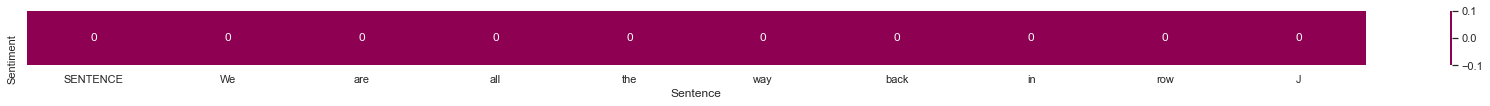

In [3]:
sentence = df['text'].iloc[271]
print(sentence)

visualise_sentiments({
    "Sentence":["SENTENCE"] + sentence.split(),
    "Sentiment":[vader.polarity_scores(sentence)["compound"]] + [vader.polarity_scores(word)["compound"] for word in sentence.split()]
})

In [4]:
scores_df = pd.DataFrame(scores)
# join it with main dataframe
df_join = df.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
df_join['message_date'] = pd.to_datetime(df_join.message_date).dt.date

# add month column
df_join['message_month'] = pd.to_datetime(df_join.message_date).dt.month_name()
df_join['message_month_number'] = pd.to_datetime(df_join.message_date).dt.month

# filter by handle id
# df_join = df_join.loc[df_join['handle_id'] == '+12032585295']

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = df_join.groupby(['message_month_number','message_month', 'is_from_me']).mean()
mean_scores.tail()

neg       neu       pos  \
message_month_number message_month is_from_me                                 
10                   October       1           0.039092  0.716313  0.232763   
11                   November      0           0.048692  0.677083  0.241527   
                                   1           0.042200  0.675715  0.241775   
12                   December      0           0.042185  0.650861  0.225590   
                                   1           0.033169  0.644748  0.238196   

                                               compound  
message_month_number message_month is_from_me            
10                   October       1           0.246471  
11                   November      0           0.243117  
                                   1           0.254015  
12                   December      0           0.223528  
                                   1           0.278107

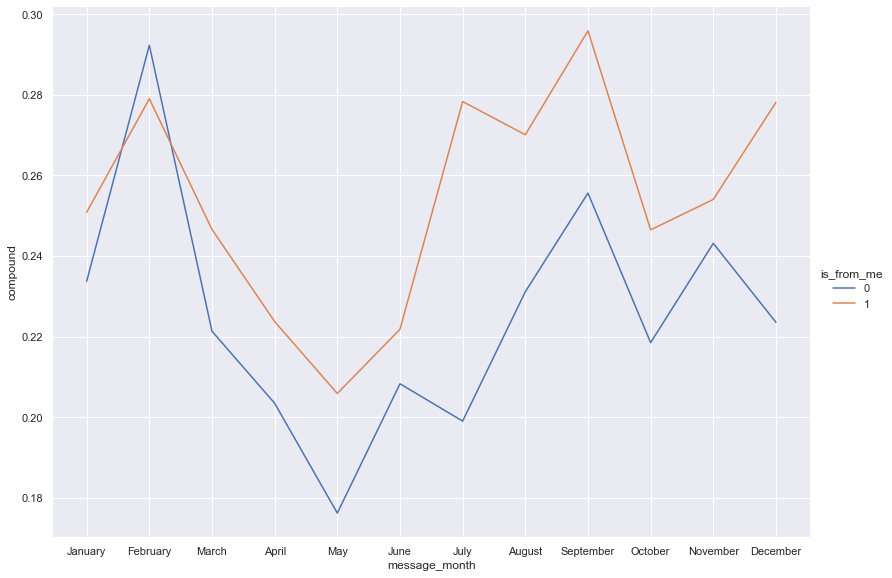

In [9]:
sns.set(rc={'figure.figsize':(20,16)})
sns.relplot(x='message_month', y='compound', hue='is_from_me', data=mean_scores, kind='line', sort=True, height=8, aspect=11.7/8.27)
# sns.catplot(x='message_month', y='compound', data=mean_scores, kind="box", dodge=False)